In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list
#! kaggle datasets download -d kazanova/sentiment140
#! unzip sentiment140.zip
#! cp tweets.csv  '/content/drive/My Drive/datasets/nlp'

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#  Dataset Preprocessing

In [4]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin')
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df['sentiment_pos'] = df['sentiment'].apply(lambda x: 1 if x==4 else 0)
df['sentiment_neg'] = df['sentiment'].apply(lambda x: 1 if x==0 else 0)
df = df.drop(['id', 'date', 'query', 'user_id','sentiment'], axis=1)
df.head()

,text,sentiment_pos,sentiment_neg
0,is upset that he can't update his Facebook by ...,0,1
1,@Kenichan I dived many times for the ball. Man...,0,1
2,my whole body feels itchy and like its on fire,0,1
3,"@nationwideclass no, it's not behaving at all....",0,1
4,@Kwesidei not the whole crew,0,1


In [5]:
df.tail()

,text,sentiment_pos,sentiment_neg
1599994,Just woke up. Having no school is the best fee...,1,0
1599995,TheWDB.com - Very cool to hear old Walt interv...,1,0
1599996,Are you ready for your MoJo Makeover? Ask me f...,1,0
1599997,Happy 38th Birthday to my boo of alll time!!! ...,1,0
1599998,happy #charitytuesday @theNSPCC @SparksCharity...,1,0


Text(0.5, 1.0, 'Data Distribution')

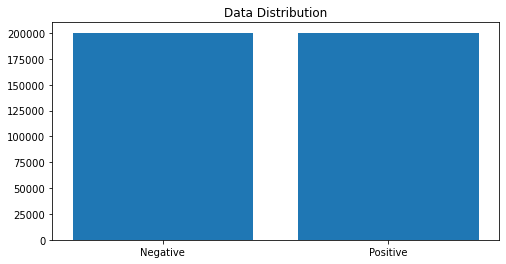

In [6]:
df = df.sample(frac = 0.25)
val_count = df.sentiment_pos.value_counts()

plt.figure(figsize=(8,4))
plt.bar(['Negative','Positive'], val_count.values)
plt.title("Data Distribution")

In [7]:
def preprocess(text, stem=False):
  text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
  stop_words = stopwords.words('english')
  stemmer = SnowballStemmer('english')
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [8]:
df.text = df.text.apply(lambda x: preprocess(x))

In [9]:
print(df.columns)

Index(['text', 'sentiment_pos', 'sentiment_neg'], dtype='object')


# Tokenization

In [10]:
x = df.text
y = df[['sentiment_pos', 'sentiment_neg']]

In [11]:
print(x)

960475          song stuck head quot shut amp let goooo quot
1292813       fashoo try best make really wanna support guys
698540     need get dressed jeremy going away party today...
93973                      craving spam misubis kbbq bwahhhh
1235083    way home woot watching fall boy vids alot than...
                                 ...                        
767489                    got test like 2 hours microbiology
611915        waited hour town hall dreading tomorrow muchly
1281211    jw level 4 admin work love staying choir pract...
636192                   forced turn friends mom spoil sport
590933     messing anymore man mom always told talk politics
Name: text, Length: 400000, dtype: object


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2500)
tfidf = vectorizer.fit(x)
processed_features = tfidf.transform(x).toarray()

In [13]:
import pickle
pickle.dump(tfidf, open("vectorizer.pickle", "wb"))

In [14]:
processed_features = processed_features.reshape(processed_features.shape[0],1,processed_features.shape[1])
print(processed_features.shape)

(400000, 1, 2500)


In [15]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [16]:
inp = Input(shape=(1,processed_features.shape[2]))
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(inp)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x)
model = tf.keras.Model(inp, outputs)

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

In [18]:
history = model.fit(processed_features, y, batch_size=512, epochs=50, validation_split=0.2, callbacks=[ReduceLROnPlateau])

Epoch 1/50
625/625 [==============================] - 7s 11ms/step - loss: 0.5274 - accuracy: 0.7329 - val_loss: 0.4962 - val_accuracy: 0.7565
Epoch 2/50
625/625 [==============================] - 6s 10ms/step - loss: 0.5054 - accuracy: 0.7494 - val_loss: 0.4929 - val_accuracy: 0.7582
Epoch 3/50
625/625 [==============================] - 5s 9ms/step - loss: 0.5010 - accuracy: 0.7522 - val_loss: 0.4922 - val_accuracy: 0.7573
Epoch 4/50
625/625 [==============================] - 6s 9ms/step - loss: 0.4968 - accuracy: 0.7544 - val_loss: 0.4910 - val_accuracy: 0.7592
Epoch 5/50
625/625 [==============================] - 6s 9ms/step - loss: 0.4932 - accuracy: 0.7571 - val_loss: 0.4889 - val_accuracy: 0.7605
Epoch 6/50
625/625 [==============================] - 6s 9ms/step - loss: 0.4892 - accuracy: 0.7598 - val_loss: 0.4895 - val_accuracy: 0.7597
Epoch 7/50
625/625 [==============================] - 6s 9ms/step - loss: 0.4850 - accuracy: 0.7627 - val_loss: 0.4874 - val_accuracy: 0.7610
Epoc

In [19]:
model.save('model.h5')

In [20]:
input_text = input()
input_text = preprocess(input_text)
vect = pickle.load(open("vectorizer.pickle",'rb'))
input_text = vect.transform([input_text]).toarray().reshape(1,1,2500)
mod = tf.keras.models.load_model('model.h5')
out = mod.predict(input_text)
plt.bar(['Positive','Negative'],out[0])

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.